Класифікація зображень з використанням LSH
Датасет: Intel Image Classification

[1] Завантаження тренувальних даних...
Завантажено тренувальних зображень: 1200
Класи: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

[2] Завантаження тестових даних...
Завантажено тестових зображень: 300

[3] Навчання LSH класифікатора...

Точність LSH: 0.3533
Час навчання: 0.04 сек
Час передбачення: 0.48 сек

Звіт класифікації (LSH):
              precision    recall  f1-score   support

   buildings       0.33      0.26      0.29        50
      forest       0.74      0.34      0.47        50
     glacier       0.28      0.40      0.33        50
    mountain       0.41      0.62      0.50        50
         sea       0.20      0.28      0.23        50
      street       0.55      0.22      0.31        50

    accuracy                           0.35       300
   macro avg       0.42      0.35      0.35       300
weighted avg       0.42      0.35      0.35       300


[4] Навчання KNN кла

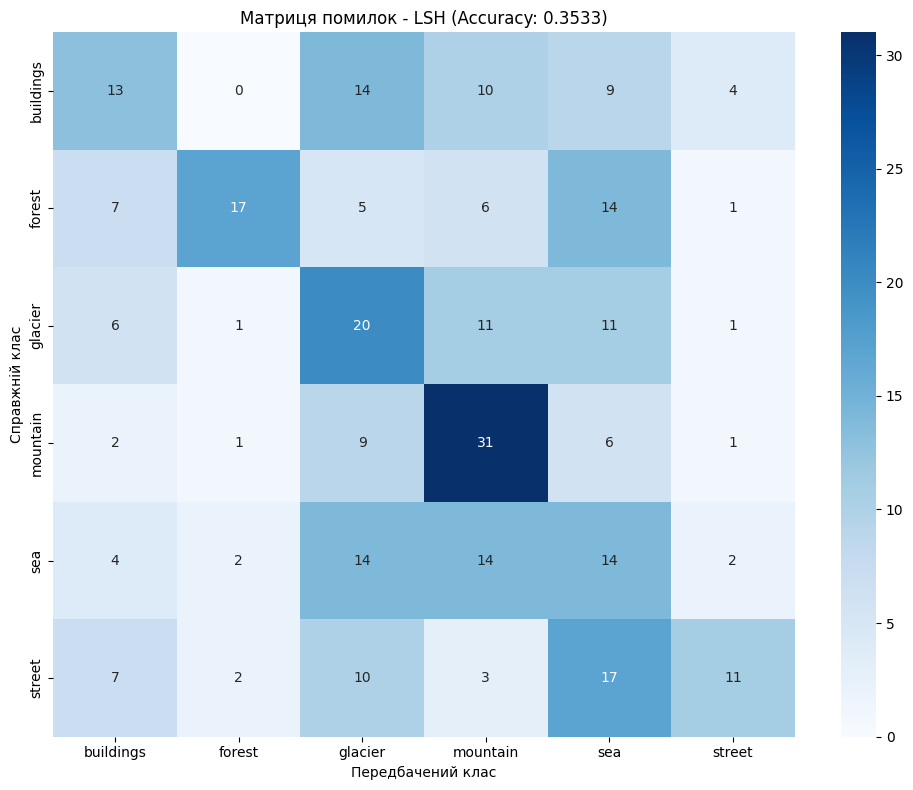

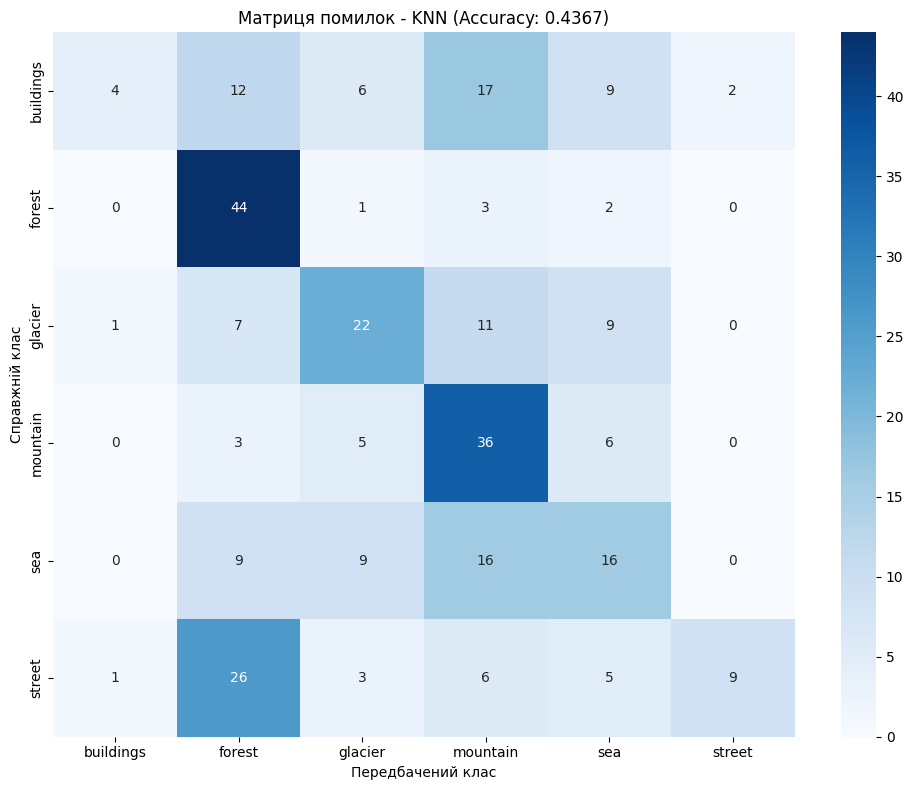

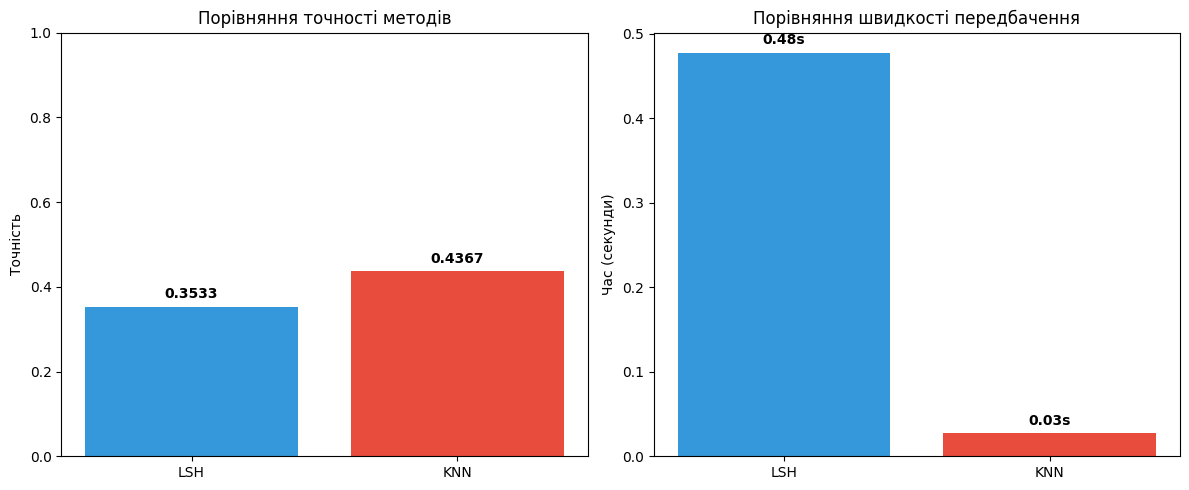

In [ ]:
import numpy as np
import os
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import time

class LSH:
    """Locality Sensitive Hashing для пошуку схожих зображень"""
    
    def __init__(self, num_buckets, num_hash_functions, input_dim):
        self.num_buckets = num_buckets
        self.num_hash_functions = num_hash_functions
        self.input_dim = input_dim
        self.hash_functions = [self._generate_hash_function() for _ in range(num_hash_functions)]
        self.buckets = defaultdict(list)
        
    def _generate_hash_function(self):
        """Генерація випадкової гіперплощини для хешування"""
        return np.random.randn(self.input_dim)
    
    def hash(self, vector):
        """Обчислення хеш-значень для вектора"""
        hashes = []
        for hash_function in self.hash_functions:
            hash_value = np.dot(vector, hash_function)
            hashes.append(1 if hash_value > 0 else 0)
        return int(''.join(map(str, hashes)), 2)
    
    def add_vector(self, vector, label, idx):
        """Додавання вектора до LSH-структури"""
        hash_value = self.hash(vector)
        bucket_id = hash_value % self.num_buckets
        self.buckets[bucket_id].append((idx, vector, label))
    
    def query(self, query_vector, k=5):
        """Пошук k найближчих сусідів через LSH"""
        query_hash = self.hash(query_vector)
        bucket_id = query_hash % self.num_buckets
        
        candidates = self.buckets[bucket_id]
        
        # Якщо в бакеті недостатньо елементів, додаємо з сусідніх
        if len(candidates) < k:
            for offset in range(1, self.num_buckets):
                candidates.extend(self.buckets[(bucket_id + offset) % self.num_buckets])
                candidates.extend(self.buckets[(bucket_id - offset) % self.num_buckets])
                if len(candidates) >= k * 2:
                    break
        
        if not candidates:
            return []
        
        # Обчислення косинусної подібності
        distances = []
        for idx, vector, label in candidates:
            similarity = np.dot(query_vector, vector) / (np.linalg.norm(query_vector) * np.linalg.norm(vector) + 1e-10)
            distances.append((similarity, label))
        
        distances.sort(reverse=True, key=lambda x: x[0])
        
        # Повернення k найближчих
        return distances[:k]

class LSHClassifier:
    """Класифікатор на основі LSH"""
    
    def __init__(self, num_buckets=100, num_hash_functions=10, k_neighbors=5):
        self.num_buckets = num_buckets
        self.num_hash_functions = num_hash_functions
        self.k_neighbors = k_neighbors
        self.lsh = None
        
    def fit(self, X_train, y_train):
        input_dim = X_train.shape[1]
        self.lsh = LSH(self.num_buckets, self.num_hash_functions, input_dim)
        
        for idx, (vector, label) in enumerate(zip(X_train, y_train)):
            self.lsh.add_vector(vector, label, idx)
    
    def predict(self, X_test):
        """Передбачення класів для тестових даних"""
        predictions = []
        
        for vector in X_test:
            neighbors = self.lsh.query(vector, k=self.k_neighbors)
            
            if not neighbors:
                predictions.append(0) 
                continue
            
            labels = [label for _, label in neighbors]
            prediction = max(set(labels), key=labels.count)
            predictions.append(prediction)
        
        return np.array(predictions)

def load_images_from_folder(folder_path, target_size=(64, 64), max_images=None):
    images = []
    labels = []
    label_names = []
    
    if not os.path.exists(folder_path):
        print(f"Папка {folder_path} не знайдена!")
        return np.array([]), np.array([]), []
    
    categories = sorted(os.listdir(folder_path))
    
    for label_idx, category in enumerate(categories):
        category_path = os.path.join(folder_path, category)
        
        if not os.path.isdir(category_path):
            continue
            
        label_names.append(category)
        image_files = os.listdir(category_path)
        
        if max_images:
            image_files = image_files[:max_images]
        
        for img_file in image_files:
            img_path = os.path.join(category_path, img_file)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(target_size)
                img_array = np.array(img).flatten() / 255.0  # Нормалізація
                images.append(img_array)
                labels.append(label_idx)
            except Exception as e:
                print(f"Помилка завантаження {img_path}: {e}")
    
    return np.array(images), np.array(labels), label_names

def plot_confusion_matrix(y_true, y_pred, label_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title(title)
    plt.ylabel('Справжній клас')
    plt.xlabel('Передбачений клас')
    plt.tight_layout()
    plt.show()

def main():
    print("=" * 60)
    print("Класифікація зображень з використанням LSH")
    print("Датасет: Intel Image Classification")
    print("=" * 60)
    
    train_path = "../DATASETS/L7/seg_train/seg_train"  
    test_path = "../DATASETS/L7/seg_test/seg_test" 
    
    print("\n[1] Завантаження тренувальних даних...")
    X_train, y_train, label_names = load_images_from_folder(
        train_path, target_size=(32, 32), max_images=200  
    )
    
    print(f"Завантажено тренувальних зображень: {len(X_train)}")
    print(f"Класи: {label_names}")
    
    print("\n[2] Завантаження тестових даних...")
    X_test, y_test, _ = load_images_from_folder(
        test_path, target_size=(32, 32), max_images=50  
    )
    
    print(f"Завантажено тестових зображень: {len(X_test)}")
    
    if len(X_train) == 0 or len(X_test) == 0:
        print("\n!!! Дані не завантажені !!!")
        return
    
    print("\n" + "=" * 60)
    print("[3] Навчання LSH класифікатора...")
    print("=" * 60)
    
    lsh_clf = LSHClassifier(num_buckets=50, num_hash_functions=12, k_neighbors=7)
    
    start_time = time.time()
    lsh_clf.fit(X_train, y_train)
    train_time_lsh = time.time() - start_time
    
    start_time = time.time()
    y_pred_lsh = lsh_clf.predict(X_test)
    predict_time_lsh = time.time() - start_time
    
    accuracy_lsh = accuracy_score(y_test, y_pred_lsh)
    
    print(f"\nТочність LSH: {accuracy_lsh:.4f}")
    print(f"Час навчання: {train_time_lsh:.2f} сек")
    print(f"Час передбачення: {predict_time_lsh:.2f} сек")
    print("\nЗвіт класифікації (LSH):")
    print(classification_report(y_test, y_pred_lsh, target_names=label_names, zero_division=0))
    
    print("\n" + "=" * 60)
    print("[4] Навчання KNN класифікатора (для порівняння)...")
    print("=" * 60)
    
    knn_clf = KNeighborsClassifier(n_neighbors=7)
    
    start_time = time.time()
    knn_clf.fit(X_train, y_train)
    train_time_knn = time.time() - start_time
    
    start_time = time.time()
    y_pred_knn = knn_clf.predict(X_test)
    predict_time_knn = time.time() - start_time
    
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    
    print(f"\nТочність KNN: {accuracy_knn:.4f}")
    print(f"Час навчання: {train_time_knn:.2f} сек")
    print(f"Час передбачення: {predict_time_knn:.2f} сек")
    print("\nЗвіт класифікації (KNN):")
    print(classification_report(y_test, y_pred_knn, target_names=label_names, zero_division=0))
    
    print("\n" + "=" * 60)
    print("ПОРІВНЯННЯ РЕЗУЛЬТАТІВ")
    print("=" * 60)
    print(f"\n{'Метрика':<30} {'LSH':<15} {'KNN':<15}")
    print("-" * 60)
    print(f"{'Точність':<30} {accuracy_lsh:.4f}{'':<10} {accuracy_knn:.4f}")
    print(f"{'Час навчання (сек)':<30} {train_time_lsh:.2f}{'':<12} {train_time_knn:.2f}")
    print(f"{'Час передбачення (сек)':<30} {predict_time_lsh:.2f}{'':<12} {predict_time_knn:.2f}")
    print(f"{'Швидкість передбачення':<30} {len(X_test)/predict_time_lsh:.1f} зобр/сек{'':<3} {len(X_test)/predict_time_knn:.1f} зобр/сек")
    
    print("\n[5] Створення візуалізацій...")
    plot_confusion_matrix(y_test, y_pred_lsh, label_names, 
                         f'Матриця помилок - LSH (Accuracy: {accuracy_lsh:.4f})')
    plot_confusion_matrix(y_test, y_pred_knn, label_names, 
                         f'Матриця помилок - KNN (Accuracy: {accuracy_knn:.4f})')
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    methods = ['LSH', 'KNN']
    accuracies = [accuracy_lsh, accuracy_knn]
    colors = ['#3498db', '#e74c3c']
    plt.bar(methods, accuracies, color=colors)
    plt.ylabel('Точність')
    plt.title('Порівняння точності методів')
    plt.ylim([0, 1])
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    
    plt.subplot(1, 2, 2)
    times = [predict_time_lsh, predict_time_knn]
    plt.bar(methods, times, color=colors)
    plt.ylabel('Час (секунди)')
    plt.title('Порівняння швидкості передбачення')
    for i, v in enumerate(times):
        plt.text(i, v + 0.01, f'{v:.2f}s', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

main()